In [3]:
code_dir = "../UXO_protected/+BTInvertPY"

In [4]:
import numpy as np
import os
import h5py
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
from scipy.spatial import cKDTree as KDTree

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize
from mpl_toolkits import mplot3d

import uxo_utils
from uxo_utils import (
    SensorInfo, Model, preCalcLoopCorners, FModParam, 
    forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix
)

In [5]:
from matplotlib import rcParams
rcParams['font.size'] = 14
np.random.seed(2020)

In [6]:
sensorinfo = uxo_utils.load_sensor_info()
ordnance = uxo_utils.load_ordnance_dict()

In [7]:
sensorinfo.name

'UltraTEMArrayNA'

In [8]:
data_directory = "../UXO_protected/data-blacktusk"
groundtruth = pd.read_excel(os.path.sep.join([data_directory, "groundtruth_Testplot5F.xlsx"]), nrows=93)

In [9]:
# H5 functions
def proc_attr(inp):
    """HDF5 - Process attributes for the input group and return them in a dictionary."""
    dic = {}
    for att in inp.attrs.keys():
        if inp.attrs[att].dtype.char == 'S':
            dic[att] = [x.strip() for x in inp.attrs[att].tostring().decode('ascii').split(',')]
        else:
            dic[att] = inp.attrs[att][0] if isinstance(inp.attrs[att],np.ndarray) and inp.attrs[att].size==1 else inp.attrs[att]
    return dic
    pass

def proc_group(inp):
    """HDF5 - A recursive function for reading datasets and attributes into a dictionary."""
    dic = {}
    dic.update(proc_attr(inp))
    for key in inp.keys():
        if isinstance(inp[key], h5py.Group):
            dic.update({key:proc_group(inp[key])})
        else:
            dic[key] = inp[key][()]
        pass
    return dic

In [10]:
dfile = os.path.join(data_directory, 'Testplot5F.h5')
f = h5py.File(dfile, 'r')
dic = proc_group(f)
f.close()

In [11]:
# Generate the sensorinfo structure
sensor_name = dic['SensorName'][0]
sensor_config = dic['SensorConfig'][0]
afile = os.path.join(code_dir,'config','sensor_definitions','{}___{}.yaml'.format(sensor_name,sensor_config))
sensorinfo = SensorInfo.fromYAML(afile)[0]

print(sensor_name)

UltraTEMArrayNA


In [12]:
xyz_dict = dic["XYZ"]
ch = xyz_dict['Info']['ChannelNames']
datai = xyz_dict['Info']['Data']['ChannelIndex'].flatten().astype(int)-1 # These are indices to the decay data
yawi = int(xyz_dict['Info']['Yaw']['ChannelIndex'])-1 # index to the yaw channel
mni = int(xyz_dict["Info"]["MeasNum"]["ChannelIndex"])-1
eastingi = int(xyz_dict["Info"]["Easting"]["ChannelIndex"])-1
northingi = int(xyz_dict["Info"]["Northing"]["ChannelIndex"])-1
linesi = int(xyz_dict["Info"]["Line"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"])-1
tx_num = int(xyz_dict["Info"]["TxNum"]["ChannelIndex"])-1
rx_comp = int(xyz_dict["Info"]["RxCNum"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"]) - 1

times = np.array(dic['SensorTimes'].flatten())
print(times.min(), times.max(), len(times))

0.154 2.42 27


In [13]:
xyz_data = xyz_dict["Data"]
mn = xyz_data[mni, :].astype(int) - 1

In [14]:
ind_tearly = [i for i, key in enumerate(xyz_dict["Channels"]) if key == 'tearly'][0]
ind_tmid = [i for i, key in enumerate(xyz_dict["Channels"]) if key == 'tmid'][0]
ind_tlate = [i for i, key in enumerate(xyz_dict["Channels"]) if key == 'tlate'][0]

In [15]:
tearly = xyz_dict["Data"][ind_tearly, :]
tmid = xyz_dict["Data"][ind_tmid, :]
tlate = xyz_dict["Data"][ind_tlate, :]
easting = xyz_dict["Data"][eastingi, :]
northing = xyz_dict["Data"][northingi, :]

cm = plt.get_cmap('viridis')
c_norm = Normalize(vmin=tmid.min(), vmax=tmid.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

In [16]:
line_inds = xyz_data[linesi, :] == 1013
tx_nums = xyz_data[tx_num, :]
rx_nums = xyz_data[rx_num, :]

In [17]:
rx_nums

array([ 1.,  1.,  1., ..., 11., 11., 11.])

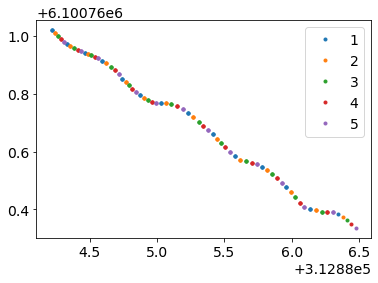

In [18]:
fig, ax = plt.subplots(1, 1)

for i in np.unique(tx_nums).astype(int):
    ii = line_inds & (tx_nums == i) & (rx_nums == 1)
    ax.plot(easting[ii][:40], northing[ii][:40], f'C{i-1}.', label=i)
ax.legend()
# ax.set_xlim([])

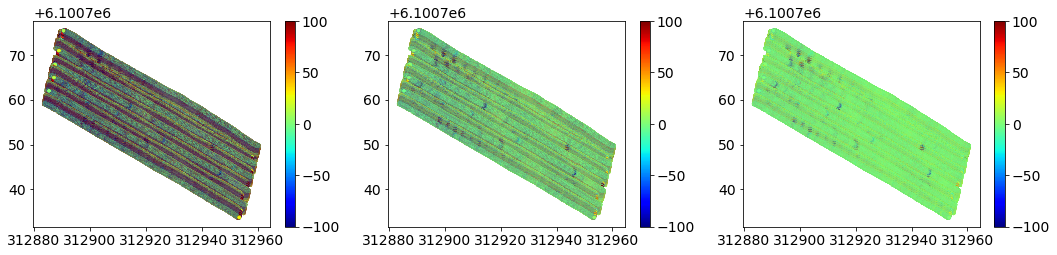

In [19]:
clim = 100*np.r_[-1, 1]
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for a, tplot in zip(ax, [tearly, tmid, tlate]):
    plt.colorbar(
        a.scatter(easting, northing, c=tplot, marker='.', cmap="jet", vmin=clim.min(), vmax=clim.max()), 
        ax=a
    )

plt.tight_layout()

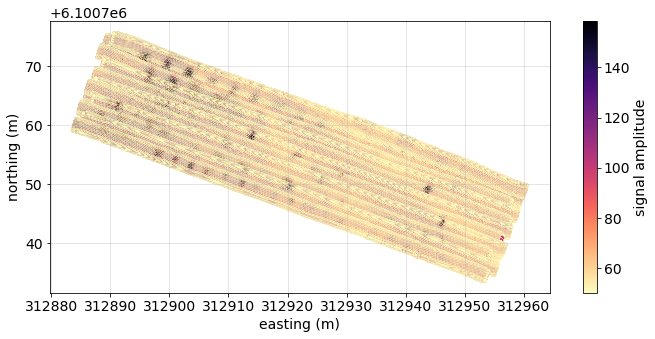

In [20]:
clim = 10**np.r_[1.7, 2.2]
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

cb = plt.colorbar(
    ax.scatter(easting, northing, c=np.abs(tmid), marker='.', cmap="magma_r", vmin=clim.min(), vmax=clim.max(), alpha=1), 
    ax=ax
)
ax.set_aspect(1)
ax.set_xlabel("easting (m)")
ax.set_ylabel("northing (m)")
cb.set_label("signal amplitude")
ax.grid(which="both", alpha=0.4)

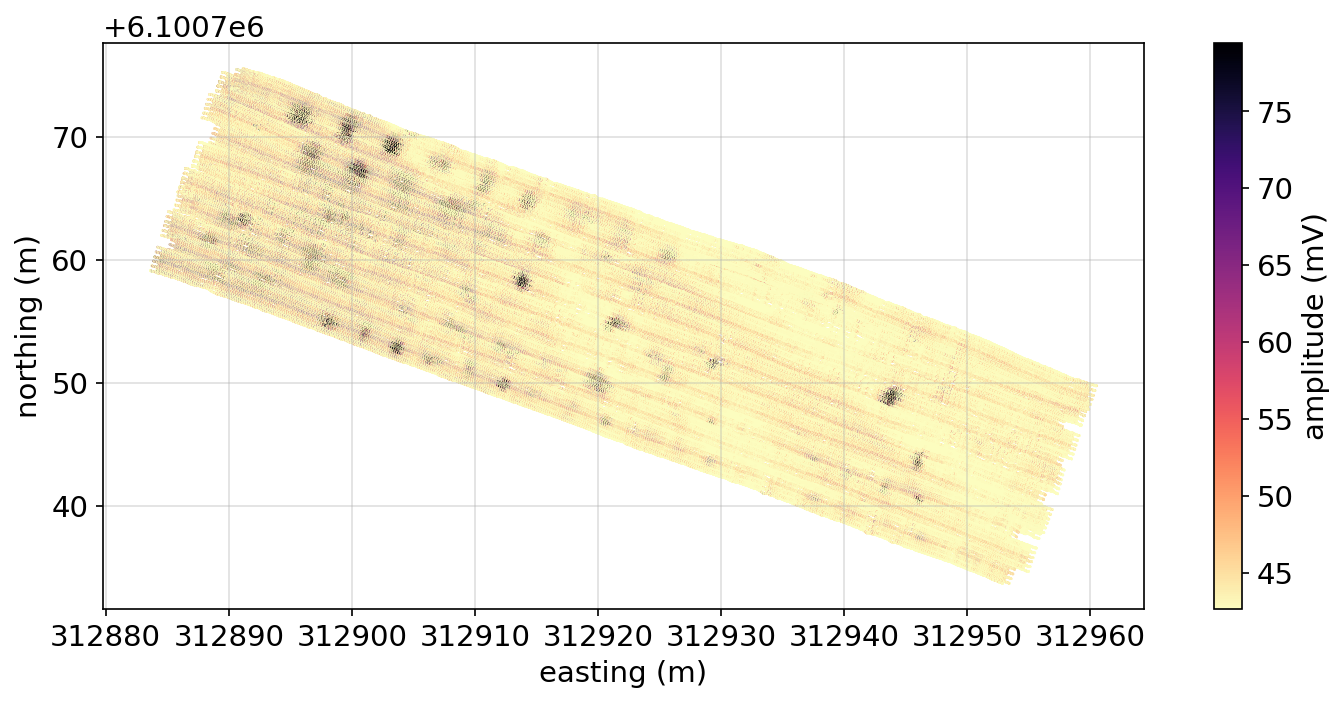

In [21]:
clim = 10**np.r_[1.63, 1.9]
fig, ax = plt.subplots(1, 1, figsize=(12, 5), dpi=150)

cb = plt.colorbar(
    ax.scatter(
        easting, northing, c=np.abs(tlate), marker='.', 
        cmap="magma_r", vmin=clim.min(), vmax=clim.max(), s=0.1
    ), 
    ax=ax
)
ax.set_aspect(1)
ax.set_xlabel("easting (m)")
ax.set_ylabel("northing (m)")
cb.set_label("amplitude (mV)")
ax.grid(which="both", alpha=0.4)

In [22]:
all_items = np.unique(groundtruth["ItemBuried"])
all_items

array(['20mm', 'EOD9115', 'EOD9145', 'EOD9146', 'EOD9147', 'EOD9148',
       'EOD9149', 'EOD9150', 'EOD9151', 'EOD9152', 'EOD9153', 'EOD9154',
       'EOD9156', 'EOD9157', 'EOD9160', 'East 5m', 'Large ISO',
       'Medium ISO', 'Native1', 'Native12', 'Native2', 'Native3',
       'Native4', 'Native5', 'Native8', 'North 5m', 'Railway',
       'Small ISO', 'South 5m', 'West 5m'], dtype=object)

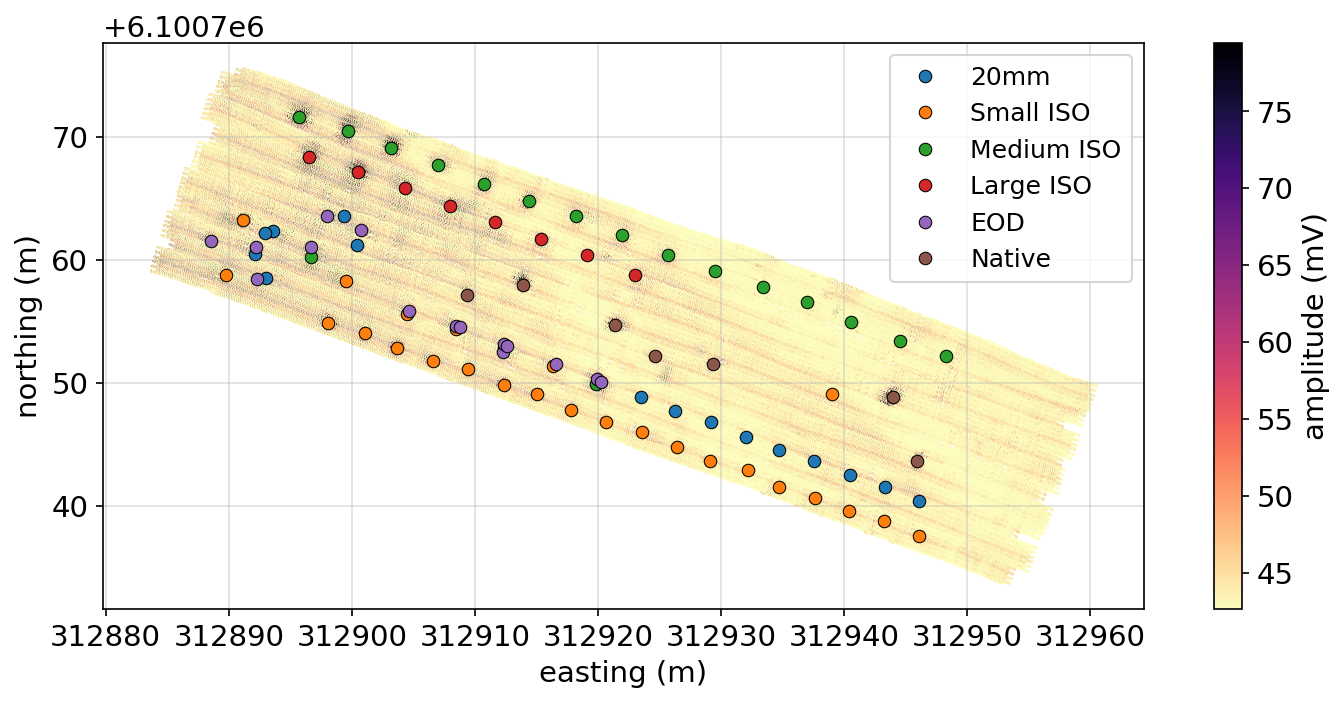

In [23]:
clim = 10**np.r_[1.63, 1.9]
fig, ax = plt.subplots(1, 1, figsize=(12, 5), dpi=150)

cb = plt.colorbar(
    ax.scatter(
        easting, northing, c=np.abs(tlate), marker='.', 
        cmap="magma_r", vmin=clim.min(), vmax=clim.max(), s=0.1
    ), 
    ax=ax
)

for i, item in enumerate(
    ["20mm", "Small ISO", "Medium ISO", "Large ISO", "EOD", "Native"]
):
    if item in ["EOD", "Native"]:
        inds = [j for j, itm in enumerate(groundtruth["ItemBuried"]) if itm.startswith(item)]
    else: 
        inds = groundtruth["ItemBuried"] == item
    plt.plot(
        groundtruth["Easting"][inds], groundtruth["Northing"][inds], f"C{i}o", 
        mec="k", mew="0.5", label=item
    )
ax.set_aspect(1)
ax.set_xlabel("easting (m)")
ax.set_ylabel("northing (m)")
cb.set_label("amplitude (mV)")
ax.grid(which="both", alpha=0.4)
ax.legend(fontsize=12)

In [ ]:
from matplotlib.colors import Normalize, SymLogNorm

ValueError: Contour levels must be increasing

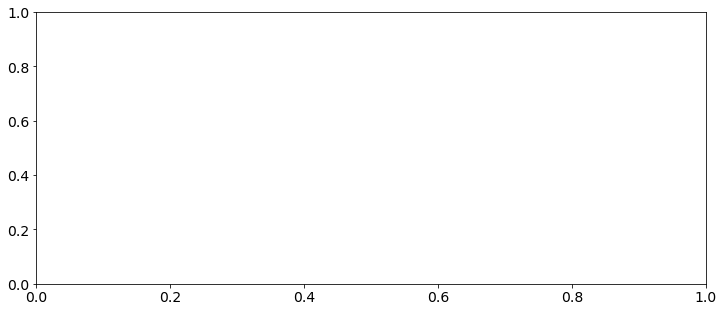

In [25]:
from scipy.spatial import Delaunay

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Create triangulation.
import matplotlib.tri as triag
tri = Delaunay(np.hstack([easting[:, None], northing[:, None]]))
# tri = triag.Triangulation(synthetic_eastings, synthetic_northings)

cb = plt.colorbar(ax.tricontourf(
    tri.points[:, 0], tri.points[:, 1],
    easting, northing, np.abs(tlate), 100,
    cmap="magma_r", vmin=clim.min(), vmax=clim.max()
    ), 
    ax=ax,
)
# cb.set_clim([0.3, 1])

ax.set_aspect(1)
ax.grid(which="both", alpha=0.4)

for i, item in enumerate(synthetic_subset["item"]):
    if item == "Small ISO":
        ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'C0o', ms=8, mec="w")
    elif item == "Medium ISO": 
        ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'C2s', ms=8, mec="w")
    elif item == "Large ISO":
        ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'C5v', ms=8, mec="w")
    elif item == "20mm":
        ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'C6d', ms=8, mec="w")

# rotate data

In [19]:
# rotate data
from scipy import stats
# local coordinates for the data set 
x0, y0 = np.mean(easting), np.mean(northing)
local_easting = easting - x0
local_northing = northing - y0

slope, intercept, _, _, _ = stats.linregress(local_easting, local_northing)
print(slope, intercept)

-0.3486944749895923 6.346738382583072e-10


In [20]:
theta = np.arctan(slope)+np.pi/2
local_x = np.cos(theta) * local_easting + np.sin(theta) * local_northing
local_y = -np.sin(theta) * local_easting + np.cos(theta) * local_northing

local_ground_truth_easting = np.array(groundtruth["Easting"] - x0)
local_ground_truth_northing = np.array(groundtruth["Northing"] - y0)
local_ground_truth_x = np.cos(theta) * local_ground_truth_easting + np.sin(theta) * local_ground_truth_northing
local_ground_truth_y = -np.sin(theta) * local_ground_truth_easting + np.cos(theta) * local_ground_truth_northing

In [28]:
nx = 50
ny = 500
gridded_x = np.linspace(local_x.min(), local_x.max(), nx)
gridded_y = np.linspace(local_y.min(), local_y.max(), ny)

XY = np.meshgrid(gridded_x, gridded_y)

In [29]:
XY[0].shape

(500, 50)

In [30]:
gridded_t_early = griddata(np.vstack([local_x, local_y]).T, tearly, tuple(XY), 'cubic')
gridded_t_mid = griddata(np.vstack([local_x, local_y]).T, tmid, tuple(XY), 'cubic')
gridded_t_late = griddata(np.vstack([local_x, local_y]).T, tlate, tuple(XY), 'cubic')

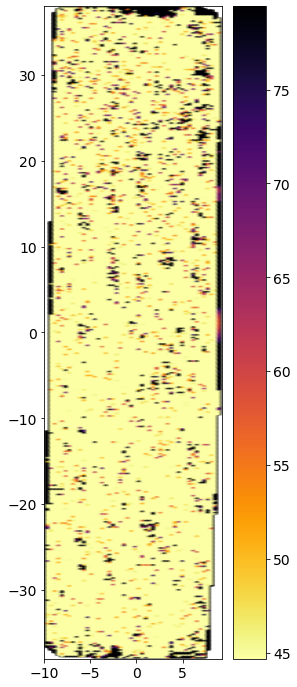

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(4, 12))
clim = 10**np.r_[1.65, 1.9]
plt.colorbar(
    plt.pcolormesh(
        gridded_x, gridded_y, np.abs(gridded_t_late), vmin=clim.min(), vmax=clim.max(), shading="gouraud",
        cmap="inferno_r",
    )
)

In [ ]:
local_x.shape